# 2025 데이터 크리에이터 캠프

@PHASE: Mission 4-2

@TEAM: 최후의 인공지능

## 1. Check GPU Availability

- GPU 번호 지정

In [1]:
!nvidia-smi

Tue Nov 25 18:57:41 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100X                   On  | 00000000:1C:00.0 Off |                    0 |
| N/A   49C    P0              72W / 300W |      0MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# Set CUDA Device Number
DEVICE_NUM = 0

from os import environ
environ["CUDA_VISIBLE_DEVICES"] = str(DEVICE_NUM)
environ["CUDA_VISIBLE_DEVICES"]

'0'

## 2. Imports

- 의존성 로드

In [3]:
from os import path, makedirs
import random
import gc

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import numpy as np

import wandb
import matplotlib.pyplot as plt
from transformers.utils.notebook import NotebookProgressBar


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"INFO: Using device - {device}")

INFO: Using device - cuda


In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
set_seed()  # 시드 고정

In [6]:
PROJECT_NAME = "Mission_4-2"
RUN_NAME = "UNet-34p"

# WandB Initialization
wandb.init(project=PROJECT_NAME, name=RUN_NAME)

wandb: Currently logged in as: brew (brew-research) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 3. Define Dataset

- 데이터셋 정의

### 3.1. 데이터셋 홀더 클래스 생성

In [7]:
from dataclasses import dataclass
from torch.utils.data import Dataset


@dataclass
class DatasetHolder:
    train: Dataset = None
    valid: Dataset = None
    test: Dataset = None

    def __post_init__(self):
        print(f"INFO: Dataset loaded successfully. Number of samples - ", end='')
        if self.train:
            print(f"Train: {len(self.train)}", end='')
        if self.valid:
            if self.train: print(', ', end='')
            print(f"Valid: {len(self.valid)}", end='')
        if self.test:
            if self.train: print(', ', end='')
            print(f"Test: {len(self.test)}", end='')
        print('\n')


@dataclass
class DataLoaderHolder:
    train: object = None
    valid: object = None
    test: object = None

### 3.2. 데이터셋 클래스 정의

#### 3.2.1. 데이터셋 인덱스 지정

In [8]:
from enum import Enum


# Github Release URL for datasets
# This will be removed after the contest ends due to the copyright issue.
base_git_path = "https://github.com/b-re-w/K-ICT_DataCreatorCamp_2025/releases/download/dt/"


class KompsatIndex(Enum):
    TRAIN = "TS_KS.zip"
    VALID = "VS_KS.zip"
    TRAIN_BBOX = "TL_KS_BBOX.zip"
    VALID_BBOX = "VL_KS_BBOX.zip"
    TRAIN_LINE = "TL_KS_LINE.zip"
    VALID_LINE = "VL_KS_LINE.zip"

    @property
    def url(self):
        return f"{base_git_path}{self.value}"


class SentinelIndex(Enum):
    TRAIN = "TS_SN10_SN10.zip"
    VALID = "VS_SN10_SN10.zip"
    TRAIN_MASK = "TL_SN10.zip"
    VALID_MASK = "VL_SN10.zip"
    TRAIN_GEMS = "TS_SN10_GEMS.zip"
    VALID_GEMS = "VS_SN10_GEMS.zip"
    TRAIN_AIR = "TS_SN10_AIR_POLLUTION.zip"
    VALID_AIR = "VS_SN10_AIR_POLLUTION.zip"

    @property
    def url(self):
        return f"{base_git_path}{self.value}"

    @property
    def urls(self):
        data_range = None
        match self:
            case SentinelIndex.TRAIN:
                data_range = range(1, 9)
            case SentinelIndex.TRAIN_GEMS:
                data_range = range(1, 3)
            case _:
                return [self.url]
        return [
            self.url.replace(".zip", f"_p{i}.zip") for i in data_range
        ]

    @property
    def names(self):
        data_range = None
        match self:
            case SentinelIndex.TRAIN:
                data_range = range(1, 9)
            case SentinelIndex.TRAIN_GEMS:
                data_range = range(1, 3)
            case _:
                return [self.value]
        return [
            self.value.replace(".zip", f"_p{i}.zip") for i in data_range
        ]


class LandsatIndex(Enum):
    TRAIN = "TS_LS30_LS30.zip"
    VALID = "VS_LS30_LS30.zip"
    TRAIN_MASK = "TL_LS30.zip"
    VALID_MASK = "VL_LS30.zip"

    @property
    def url(self):
        return f"{base_git_path}{self.value}"

    @property
    def urls(self):
        return [self.url]

    @property
    def names(self):
        return [self.value]

#### 3.2.2. 목적별 데이터셋 정의

In [9]:
import traceback
from os import path
from glob import glob
from enum import Enum
from pathlib import Path
from typing import Union, Optional, Callable

import numpy as np
import torch

from torchvision.datasets import VisionDataset, utils
import rasterio

from tqdm.asyncio import tqdm
import concurrent.futures
import asyncio

import nest_asyncio
nest_asyncio.apply()


class DatasetModals(Enum):
    RGB = "rgb"
    NIR = "nir"
    GEMS = "gems"
    AIR = "air"


class SentinelDataset(VisionDataset):
    dataset_name = "Sentinel"

    CLASSES = "background", "industrial_area"  # Class definitions: 0=background, 1=industrial_area
    PALETTE = [0], [1]  # Grayscale palette | Background: black, Industrial area: white
    ORIGINAL_PALETTE = [90, 90, 90], [10, 10, 10]  # Background: gray, Industrial area: black

    DIRECTORIES = ["images", "masks", "gems", "air"]
    DATA_LIST = [
        SentinelIndex.TRAIN, SentinelIndex.VALID,
        SentinelIndex.TRAIN_MASK, SentinelIndex.VALID_MASK,
        SentinelIndex.TRAIN_GEMS, SentinelIndex.VALID_GEMS,
        SentinelIndex.TRAIN_AIR, SentinelIndex.VALID_AIR,
    ]
    TRAIN_LIST = [SentinelIndex.TRAIN, SentinelIndex.TRAIN_MASK, SentinelIndex.TRAIN_GEMS, SentinelIndex.TRAIN_AIR]  # should be matched order with extract_dirs and valid_list
    VALID_LIST = [SentinelIndex.VALID, SentinelIndex.VALID_MASK, SentinelIndex.VALID_GEMS, SentinelIndex.VALID_AIR]

    @classmethod
    async def download_method(cls, url, root, filename):
        loop = asyncio.get_event_loop()
        with concurrent.futures.ThreadPoolExecutor() as executor:
            await loop.run_in_executor(executor, utils.download_url, url, root, filename)

    @classmethod
    async def extract_method(cls, from_path, to_path):
        try:
            loop = asyncio.get_event_loop()
            with concurrent.futures.ThreadPoolExecutor() as executor:
                await loop.run_in_executor(executor, utils.extract_archive, from_path, to_path)
        except FileExistsError as e:
            traceback.print_exc()
            raise FileExistsError(str(e) + "\nPlease use Python 3.13 or later. 3.12 or earlier versions not support unzip over existing directory.")

    def __init__(
        self,
        root: Union[str, Path] = None,
        train: bool = True,
        data_type: DatasetModals | list[DatasetModals] = DatasetModals.RGB,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ):
        """
        Sentinel-2 dataset for semantic segmentation.
        
        Args:
            root: Dataset root directory
            train: True for training set, False for validation set
            transforms: Joint transforms for image+mask
            transform: Image transforms
            target_transform: Mask transforms
        """
        super().__init__(root, transforms=transforms, transform=transform, target_transform=target_transform)

        loop = asyncio.get_event_loop()
        loop.run_until_complete(self.download(root))

        self.types = data_type if isinstance(data_type, list) else [data_type]
        self.root = path.join(root, self.dataset_name)
        self.train = train
        split = "train" if train else "val"
        self.images, self.masks, self.gems, self.air = lists = [], [], [], []
        extract_dirs = [path.join(self.root, anno, split) for anno in self.DIRECTORIES]
        for lst, anno in zip(lists, self.DIRECTORIES):
            lst.extend(sorted(glob(path.join(extract_dirs[self.DIRECTORIES.index(anno)], "*.tif"))))

        assert len(self.images) == len(self.masks), \
            f"Number of images ({len(self.images)}) and masks ({len(self.masks)}) do not match."
        if DatasetModals.GEMS in self.types:
            assert len(self.images) == len(self.gems), \
                f"Number of images ({len(self.images)}) and GEMS data ({len(self.gems)}) do not match."
        if DatasetModals.AIR in self.types:
            assert len(self.images) == len(self.air), \
                f"Number of images ({len(self.images)}) and AIR data ({len(self.air)}) do not match."

        self.cached_data = {}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if idx in self.cached_data:
            image, mask, gems, air = self.cached_data[idx]
        else:
            # Load image/mask using default_loader
            image = self.load_raster(self.images[idx], channels=(1, 2, 3, 4) if DatasetModals.NIR in self.types else (1, 2, 3), normalize=True)
            mask = self.load_raster(self.masks[idx])

            # Convert mask to grayscale
            mask = torch.where(mask == 10, 1, 0).to(torch.uint8)

            # Load additional data if specified
            gems, air = None, None
            if DatasetModals.GEMS in self.types:
                gems = self.load_raster(self.gems[idx], channels=range(1, 11), normalize=True)
            if DatasetModals.AIR in self.types:
                air = self.load_raster(self.air[idx], channels=range(1, 7), normalize=True)
    
            # Cache the loaded data
            self.cached_data[idx] = (image, mask, gems, air)

        # Apply transforms
        if self.transforms:
            # Joint transforms (e.g., albumentations)
            try:
                image, mask, gems, air = self.transforms(image, mask, gems, air)
            except Exception:
                image, mask = self.transforms(image, mask)
        else:
            # Individual transforms
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                try:
                    mask, gems, air = self.target_transform(mask, gems, air)
                except Exception:
                    mask = self.target_transform(mask)

        return image, mask, gems, air

    def load_raster(self, path: Path, channels=(1,), normalize=False) -> torch.Tensor:
        """
        Load TIF image using rasterio.
    
        Args:
            path: Path to TIF file
            channels: Channels to read (1-based indexing)
            normalize: Whether to normalize the image to 0-1 range
    
        Returns:
            Normalized image array in (C, H, W) format
        """
        with rasterio.open(path) as src:
            data = src.read(channels)

        # Normalize to 0-1
        if normalize:
            data = data.astype(np.float32)
            # Channel-wise Z-score normalization
            for i in range(data.shape[0]):
                channel_min = data[i].min()
                channel_max = data[i].max()
                diff = channel_max - channel_min
                if diff != 0:
                    data[i] = (data[i] - channel_min) / diff
                else:
                    data[i] = 0
        return torch.from_numpy(data)

    @classmethod
    async def download(cls, root: str):
        dataset_root = path.join(root, cls.dataset_name)
        if path.exists(dataset_root):  # If the dataset directory already exists, skip download
            return

        print(f"INFO: Downloading '{cls.dataset_name}' from server to {root}...")
        routines = []
        for data in cls.DATA_LIST:
            if path.isfile(path.join(root, data.value)):
                print(f"INFO: Dataset archive {data.value} found in the root directory. Skipping download.")
                continue

            routines.extend(cls.download_method(url, root=root, filename=file) for url, file in zip(data.urls, data.names))
        await tqdm.gather(*routines, desc=f"Downloading {len(routines)} files")

        print(f"INFO: Extracting '{cls.dataset_name}' dataset...")
        routines = []
        as_train, as_valid = lambda d: path.join(d, "train"), lambda d: path.join(d, "val")
        extract_dirs = [path.join(dataset_root, anno) for anno in cls.DIRECTORIES]
        for trains, dirs in zip(cls.TRAIN_LIST, extract_dirs):
            routines.extend(cls.extract_method(path.join(root, file), to_path=as_train(dirs)) for file in trains.names)
        for valids, dirs in zip(cls.VALID_LIST, extract_dirs):
            routines.extend(cls.extract_method(path.join(root, file), to_path=as_valid(dirs)) for file in valids.names)

        await tqdm.gather(*routines, desc=f"Extracting {len(routines)} files")


class SentinelDatasetForSegmentation(SentinelDataset):
    pass

In [10]:
from typing import Union, Optional, Callable
from pathlib import Path


class LandsatDataset(SentinelDataset):
    dataset_name = "Landsat"

    CLASSES = "background", "urban_area"  # Class definitions: 0=background, 1=urban_area
    PALETTE = [0], [1]  # Grayscale palette | Background: black, Urban area: white
    ORIGINAL_PALETTE = [90, 90, 90], [10, 10, 10]  # Background: gray, Urban area: black

    DIRECTORIES = ["images", "masks"]
    DATA_LIST = [
        LandsatIndex.TRAIN, LandsatIndex.VALID,
        LandsatIndex.TRAIN_MASK, LandsatIndex.VALID_MASK
    ]
    TRAIN_LIST = [LandsatIndex.TRAIN, LandsatIndex.TRAIN_MASK]  # should be matched order with extract_dirs and valid_list
    VALID_LIST = [LandsatIndex.VALID, LandsatIndex.VALID_MASK]

    def __init__(
        self,
        root: Union[str, Path] = None,
        train: bool = True,
        data_type: DatasetModals | list[DatasetModals] = DatasetModals.RGB,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None
    ):
        types = [dt for dt in data_type if dt in (DatasetModals.RGB, DatasetModals.NIR)]
        super().__init__(root, train, types, transforms, transform, target_transform)


class LandsatDatasetForSegmentation(LandsatDataset):
    pass

#### 3.2.3. 데이터셋 인스턴스 생성

- Train, Valid

##### 3.2.3.1. 인스턴스 생성

In [11]:
DATA_ROOT = path.join(".", "data")

# 모달리티 설정
modals = [DatasetModals.RGB, DatasetModals.NIR]

sentinels = DatasetHolder(
    train=SentinelDatasetForSegmentation(root=DATA_ROOT, train=True, data_type=modals),
    valid=SentinelDatasetForSegmentation(root=DATA_ROOT, train=False, data_type=modals)
)
sentinels.test = sentinels.valid  # test set은 valid set과 동일

landsats = DatasetHolder(
    train=LandsatDatasetForSegmentation(root=DATA_ROOT, train=True, data_type=modals),
    valid=LandsatDatasetForSegmentation(root=DATA_ROOT, train=False, data_type=modals)
)
landsats.test = landsats.valid  # test set은 valid set과 동일

INFO: Dataset loaded successfully. Number of samples - Train: 8000, Valid: 1000

INFO: Dataset loaded successfully. Number of samples - Train: 4000, Valid: 500



In [12]:
# 데이터셋 경로 확인
sentinels.train.images[0], sentinels.train.masks[0]

('./data/Sentinel/images/train/SN10_CHN_00001_230409.tif',
 './data/Sentinel/masks/train/SN10_CHN_00001_230409.tif')

In [13]:
# 출력 검증
sentinels.train[0]

/home/elicer/K-ICT_DataCreatorCamp_2025_PVT/.venv/lib/python3.13/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(tensor([[[0.0258, 0.0249, 0.0252,  ..., 0.1498, 0.1602, 0.1623],
          [0.0245, 0.0251, 0.0261,  ..., 0.1383, 0.1697, 0.1835],
          [0.0268, 0.0288, 0.0268,  ..., 0.1486, 0.1849, 0.1884],
          ...,
          [0.6881, 0.5596, 0.5427,  ..., 0.0554, 0.0900, 0.2466],
          [0.7438, 0.6394, 0.6224,  ..., 0.0603, 0.1039, 0.2682],
          [0.7989, 0.7212, 0.6401,  ..., 0.0653, 0.1316, 0.2929]],
 
         [[0.0411, 0.0455, 0.0463,  ..., 0.1237, 0.1301, 0.1277],
          [0.0385, 0.0397, 0.0416,  ..., 0.1216, 0.1433, 0.1440],
          [0.0385, 0.0429, 0.0461,  ..., 0.1281, 0.1508, 0.1304],
          ...,
          [0.5874, 0.4572, 0.4633,  ..., 0.0555, 0.0712, 0.1858],
          [0.6275, 0.5501, 0.5237,  ..., 0.0573, 0.0967, 0.2051],
          [0.6872, 0.6254, 0.5583,  ..., 0.0575, 0.1243, 0.2078]],
 
         [[0.1615, 0.1710, 0.1696,  ..., 0.2102, 0.2184, 0.2167],
          [0.1664, 0.1686, 0.1686,  ..., 0.2056, 0.2311, 0.2321],
          [0.1674, 0.1686, 0.1708,  ...,

In [14]:
sentinels.train[0][0].shape

torch.Size([4, 512, 512])

##### 3.2.3.2 출력 시각화

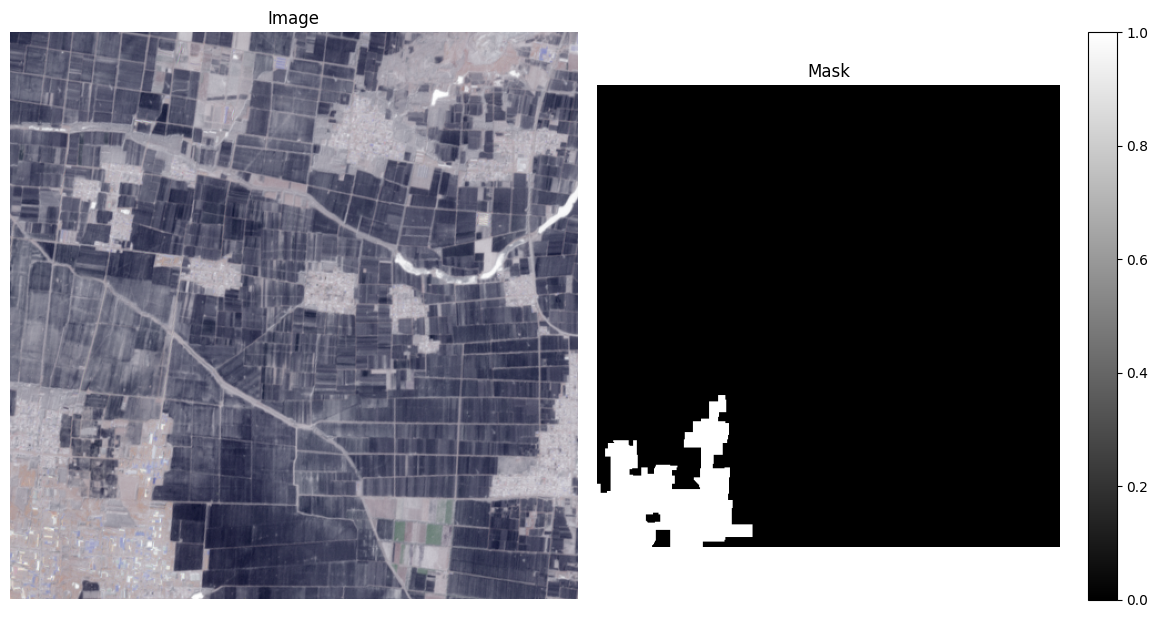

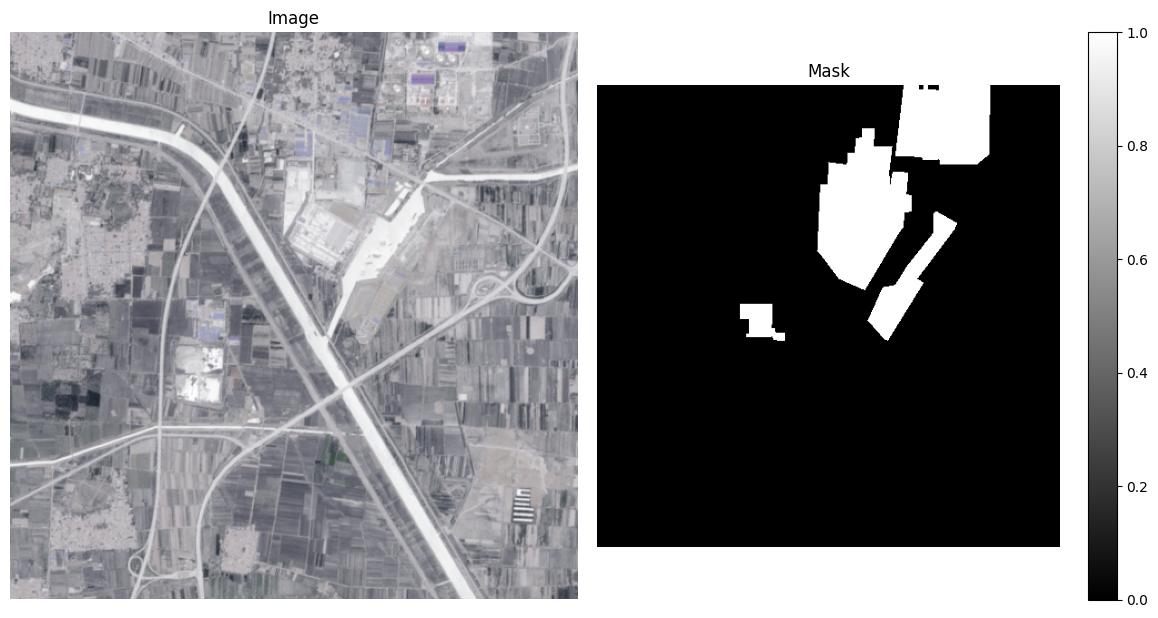

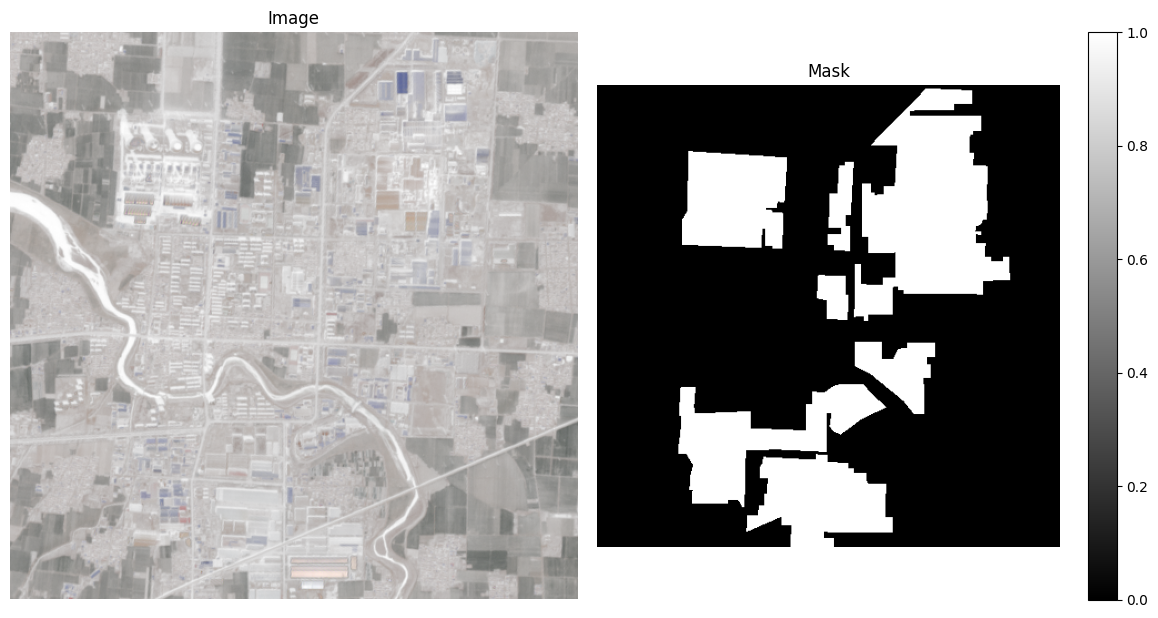

In [15]:
for idx in [0, 100, 1000]:
    rgb_image, mask_image, _, _ = sentinels.train[idx]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(rgb_image.permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image.squeeze(), cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.tight_layout()
    plt.colorbar(axes[1].imshow(mask_image.squeeze(), cmap='gray'), ax=axes[1])
    plt.show()

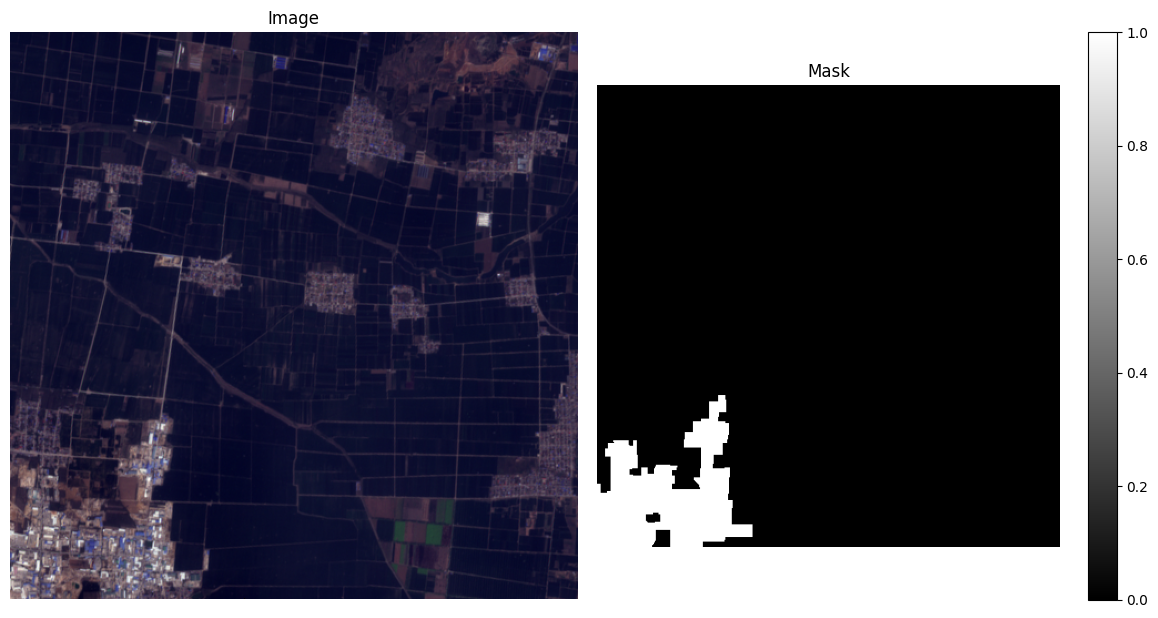

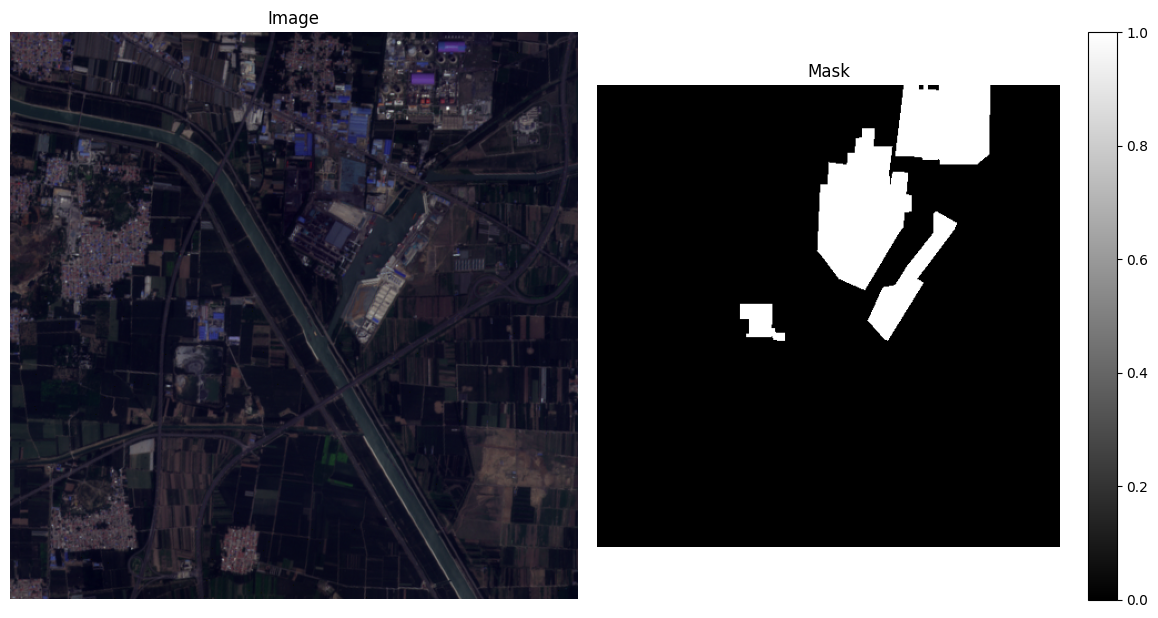

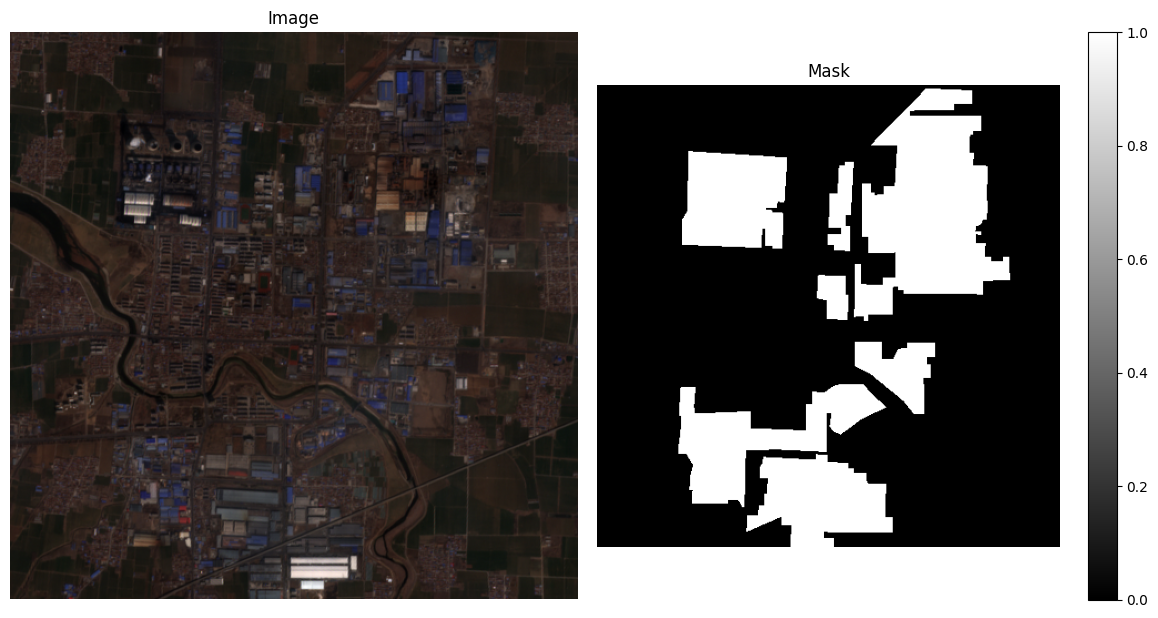

In [16]:
# RGB 채널만 시각화
for idx in [0, 100, 1000]:
    rgb_image, mask_image, _, _ = sentinels.train[idx]
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(rgb_image[:3, :, :].permute(1, 2, 0))
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask_image.squeeze(), cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis('off')

    plt.tight_layout()
    plt.colorbar(axes[1].imshow(mask_image.squeeze(), cmap='gray'), ax=axes[1])
    plt.show()

NDVI 계산 완료!
NDVI 값 범위: -1.000 ~ 1.000


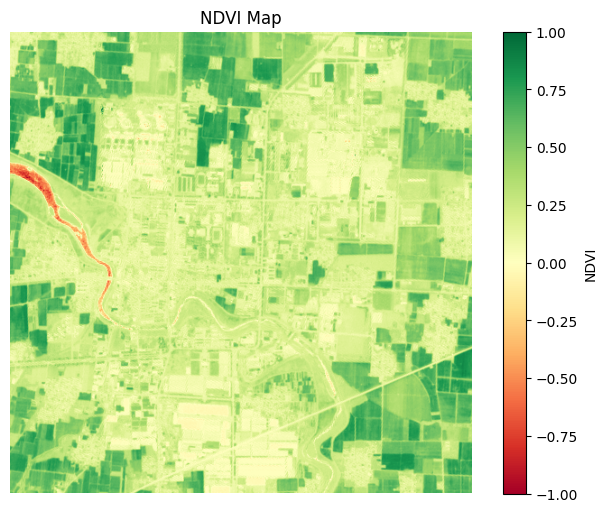

In [17]:
# NDVI 계산
rgb_image, _, _, _ = sentinels.train[1000]
nir, red = rgb_image[3, :, :], rgb_image[0, :, :]  # NIR 채널과 Red 채널 추출
denominator = nir + red
ndvi = torch.where(denominator > 0, (nir - red) / denominator, 0)

print("NDVI 계산 완료!")
print(f"NDVI 값 범위: {ndvi.min():.3f} ~ {ndvi.max():.3f}")

# NDVI 시각화
plt.figure(figsize=(8,6))
plt.imshow(ndvi, cmap='RdYlGn')  # 빨강=낮음(식생 없음), 초록=높음(식생 풍부)
plt.colorbar(label="NDVI")
plt.title("NDVI Map")
plt.axis("off")
plt.show()

## 4. DataLoader

- 데이터 로더 생성
- A100 기준 배치 크기

In [18]:
# Set Batch Size
PRETRAIN_BATCH_SIZE = 160, 500
BATCH_SIZE = 64, 128, 128
#PRETRAIN_BATCH_SIZE = 2, 8, 8
#BATCH_SIZE = 2, 8, 8

# Workers
WORKERS = 32

print(f"INFO: Set batch size - Train: {BATCH_SIZE[0]}, Valid: {BATCH_SIZE[1]}, Test: {BATCH_SIZE[2]}")

INFO: Set batch size - Train: 64, Valid: 128, Test: 128


In [19]:
def collate_fn(batch):
    images, masks, gems, air = zip(*batch)
    images = torch.stack(images)
    masks = torch.stack(masks)
    gems = torch.stack(gems) if gems[0] is not None else None
    air = torch.stack(air) if air[0] is not None else None
    return images, masks, gems, air

In [20]:
sentinel_loaders = DataLoaderHolder(
    train=DataLoader(sentinels.train, batch_size=BATCH_SIZE[0], shuffle=True, num_workers=WORKERS, collate_fn=collate_fn),
    valid=DataLoader(sentinels.valid, batch_size=BATCH_SIZE[1], shuffle=False, num_workers=WORKERS, collate_fn=collate_fn),
)
sentinel_loaders.test = sentinel_loaders.valid
landsat_loaders = DataLoaderHolder(
    train=DataLoader(landsats.train, batch_size=PRETRAIN_BATCH_SIZE[0], shuffle=True, num_workers=WORKERS, collate_fn=collate_fn),
    valid=DataLoader(landsats.valid, batch_size=PRETRAIN_BATCH_SIZE[1], shuffle=False, num_workers=WORKERS, collate_fn=collate_fn)
)
landsat_loaders.test = landsat_loaders.valid

In [ ]:
def overlay_mask(image, mask, alpha=0.4, color=(1,0,0)):
    """
    image: (H,W,3) RGB
    mask:  (H,W) binary mask (0 or 1)
    alpha: 투명도
    color: 오버레이 색상 (R,G,B)
    """
    overlay = image.numpy().copy()
    overlay[mask > 0.5] = (1-alpha)*overlay[mask > 0.5] + alpha*np.array(color)
    return overlay


def visualize_overlay(X, Y, num_samples=3, set_name="Train"):
    idxs = random.sample(range(len(X)), num_samples)
    plt.figure(figsize=(12, num_samples*4))

    for i, idx in enumerate(idxs):
        img = X[idx]
        label = Y[idx]

        # 원본
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(img[:3, :, :].permute(1, 2, 0))
        plt.title(f"{set_name} Image {idx}")
        plt.axis("off")

        # 마스크
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(label.squeeze(), cmap="gray")
        plt.title("Foreground Mask")
        plt.axis("off")

        # 오버레이
        overlayed = overlay_mask(img[:3, :, :].permute(1, 2, 0), label.squeeze())
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(overlayed)
        plt.title("Overlay")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# 배치 데이터 시각화
train_sample = next(iter(sentinel_loaders.train))
valid_sample = next(iter(sentinel_loaders.valid))
visualize_overlay(train_sample[0], train_sample[1], num_samples=2, set_name="Train")
visualize_overlay(valid_sample[0], valid_sample[1], num_samples=2, set_name="Valid")

## 5. Define Model

- 모델 정의

In [ ]:
class NotebookProgressCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_progress_bar = None
        self.val_progress_bar = None
        self.best_val_miou = 0.0

    def on_train_epoch_start(self, trainer, pl_module):
        total_batches = len(trainer.train_dataloader)
        self.train_progress_bar = NotebookProgressBar(
            total_batches, prefix=f"Training {trainer.current_epoch + 1}",
        )

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        metrics = trainer.callback_metrics
        loss = metrics.get('train_loss_step', 0)
        miou = metrics.get('train_miou_step', 0)
        current_lr = trainer.optimizers[0].param_groups[0]['lr']
        self.train_progress_bar.update(batch_idx+1, comment=f"Loss={loss:.4f}, mIoU={miou:.4f}, LR={current_lr:.2e}")

    def on_validation_epoch_start(self, trainer, pl_module):
        total_batches = len(trainer.val_dataloaders)
        self.val_progress_bar = NotebookProgressBar(
            total_batches, prefix=f"Validating {trainer.current_epoch + 1}"
        )

    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        total_batches = len(trainer.val_dataloaders)
        if batch_idx < total_batches-1:
            self.val_progress_bar.update(batch_idx+1, comment="")

    def on_validation_epoch_end(self, trainer, pl_module):
        metrics = trainer.callback_metrics
        val_loss = metrics.get('val_loss', 0)
        val_miou = metrics.get('val_miou', 0)
        self.val_progress_bar.update(self.val_progress_bar.total, comment=f"Loss={val_loss:.4f}, mIoU={val_miou:.4f}")
        if val_miou > self.best_val_miou:
            self.best_val_miou = val_miou
            print(f"Best mIoU so far: {self.best_val_miou:.4f}", flush=True)

In [ ]:
class SegmentationModel(pl.LightningModule):
    def __init__(self, learning_rate=1e-4):
        super().__init__()
        self.save_hyperparameters()

        # 모델 정의
        self.model = smp.Unet(
            encoder_name="resnet34", encoder_weights="imagenet",
            in_channels=4, classes=1,
            encoder_depth=5, decoder_channels=(512, 256, 128, 64, 64)
        )

        # 손실 함수 정의
        self.criterion = nn.BCEWithLogitsLoss()

        # mIoU 계산을 위한 변수
        self.validation_step_outputs = []

    def forward(self, x):
        return self.model(x)

    def calculate_miou(self, preds, masks, threshold=0.5):
        """mIoU 계산 함수"""
        preds = (torch.sigmoid(preds) > threshold).float()
        masks = masks.float()

        # Intersection and Union
        intersection = (preds * masks).sum(dim=(1, 2, 3))
        union = preds.sum(dim=(1, 2, 3)) + masks.sum(dim=(1, 2, 3)) - intersection

        # IoU 계산 (union이 0인 경우 처리)
        iou = (intersection + 1e-6) / (union + 1e-6)
        return iou.mean()

    def training_step(self, batch, batch_idx):
        images, masks, _, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())
        batch_size = images.size(0)

        # mIoU 계산
        miou = self.calculate_miou(outputs, masks)

        # 로깅 - step과 epoch 둘 다
        self.log('train_loss', loss, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_loss_step', loss, prog_bar=False, on_step=True, on_epoch=False, batch_size=batch_size)
        self.log('train_miou', miou, prog_bar=False, on_step=False, on_epoch=True)
        self.log('train_miou_step', miou, prog_bar=False, on_step=True, on_epoch=False, batch_size=batch_size)

        # WandB 로깅
        wandb.log({
            'train_loss': loss.item(), 
            'train_miou': miou.item(),
            'step': self.global_step
        })

        return loss

    def validation_step(self, batch, batch_idx):
        images, masks, _, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())

        # mIoU 계산
        miou = self.calculate_miou(outputs, masks)

        # 결과 저장
        self.validation_step_outputs.append({
            'val_loss': loss,
            'val_miou': miou
        })

        return {'val_loss': loss, 'val_miou': miou}

    def on_validation_epoch_end(self):
        # 에폭별 평균 계산
        avg_loss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
        avg_miou = torch.stack([x['val_miou'] for x in self.validation_step_outputs]).mean()

        # 로깅
        self.log('val_loss', avg_loss, prog_bar=False)
        self.log('val_miou', avg_miou, prog_bar=False)

        # WandB 로깅
        wandb.log({
            'val_loss': avg_loss.item(),
            'val_miou': avg_miou.item(),
            'epoch': self.current_epoch
        })

        # 초기화
        self.validation_step_outputs.clear()

    def test_step(self, batch, batch_idx):
        images, masks, _, _ = batch
        outputs = self(images)
        loss = self.criterion(outputs, masks.float())

        # mIoU 계산
        miou = self.calculate_miou(outputs, masks)

        self.log('test_loss', loss)
        self.log('test_miou', miou)

        return {'test_loss': loss, 'test_miou': miou}

    def reset_optimizers_cache(self):
        if hasattr(self, '_optim_dict_cache'):
            del self._optim_dict_cache

    def configure_optimizers(self, learning_rate=None, max_epochs=None):
        if hasattr(self, '_optim_dict_cache'):
            return self._optim_dict_cache
        else:
            self.hparams.learning_rate = learning_rate if learning_rate is not None else 1e-4
            optimizer = optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)

            # Cosine Annealing Scheduler
            self.hparams.max_epochs = max_epochs if max_epochs is not None else 50
            scheduler = optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=self.hparams.max_epochs,
                eta_min=1e-6
            )

            self._optim_dict_cache = {
                'optimizer': optimizer,
                'lr_scheduler': {
                    'scheduler': scheduler,
                    'interval': 'epoch',
                    'frequency': 1
                }
            }

            return self._optim_dict_cache

In [ ]:
# 모델 생성
torch.cuda.empty_cache()
gc.collect()

set_seed(2025)
model = SegmentationModel(learning_rate=1e-4)

model.to(device)

## 6. Train

- Epoch 기반 학습 진행

### 6.1. Landsat 데이터셋으로 프리트레이닝

In [ ]:
EPOCHS = 100
LEARNING_RATE = 1e-4

set_seed(2025)
model.configure_optimizers(learning_rate=LEARNING_RATE, max_epochs=EPOCHS)
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, enable_progress_bar=False, callbacks=[NotebookProgressCallback()], enable_model_summary=True)

In [ ]:
trainer.fit(
    model,
    train_dataloaders=landsat_loaders.train,
    val_dataloaders=landsat_loaders.valid,
)

In [ ]:
# 중간 결과 저장
makedirs("./results/", exist_ok=True)
save_path = f"./results/mission_4__temp1.pt"
torch.save(model.state_dict(), save_path)
print("INFO: Final model saved to", save_path)

In [ ]:
model.load_state_dict(torch.load("results/mission_4__temp1.pt"))

In [ ]:
landsats.train.cached_data = {}
landsats.valid.cached_data = {}

torch.cuda.empty_cache()
gc.collect()

### 6.2. Sentinel 데이터셋으로 최종 학습 진행

In [ ]:
model.reset_optimizers_cache()

In [ ]:
EPOCHS = 50
LEARNING_RATE = 1e-4

set_seed(2025)
model.configure_optimizers(learning_rate=LEARNING_RATE, max_epochs=EPOCHS)
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, enable_progress_bar=False, callbacks=[NotebookProgressCallback()], enable_model_summary=True)

In [ ]:
trainer.fit(
    model,
    train_dataloaders=sentinel_loaders.train,
    val_dataloaders=sentinel_loaders.valid,
)

In [ ]:
# 최종 결과 저장
makedirs("./results/", exist_ok=True)
save_path = f"./results/mission_4__temp2.pt"
torch.save(model.state_dict(), save_path)
print("INFO: Final model saved to", save_path)

## 7. Evaluate

- 최종 성능 확인 및 모델 저장

In [ ]:
print("\n=== Final Evaluation ===")
trainer.test(model, dataloaders=sentinel_loaders.test)

In [ ]:
makedirs("./results/", exist_ok=True)
save_path = f"./results/mission_4-2.pt"
torch.save(model.state_dict(), save_path)
print("INFO: Final model saved to", save_path)

In [ ]:
# 모델 정상 저장 확인
model.load_state_dict(torch.load(save_path))